In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict, namedtuple
import itertools
from abc import abstractmethod
from functools import lru_cache

import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import colorcet as cc
import cv2

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import tabulate

from quinn_embedding_stimuli import *
from quinn_embedding_models import *

In [3]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

In [177]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight', should_print=False):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

## Object generator and sample

In [41]:
def plot_generator_examples(generator):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((30, 30 + (i * 30)), reference_positions, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

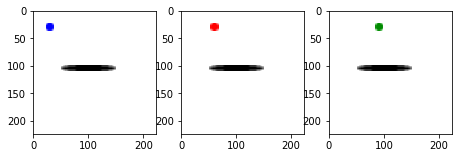

In [46]:
target_size = 15
reference_size = (10, 100)
reference_positions = [(105, 100)]

blue_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='blue')
red_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='red')
green_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='green')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='black')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
gen = PatchStimulusGenerator(target_size, reference_size, [blue_target_patch, red_target_patch, green_target_patch], 
                             reference_patch, blur_func=blur_func)

plot_generator_examples(gen)

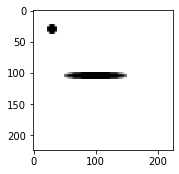

In [47]:
target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='black')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
same_color_gen = PatchStimulusGenerator(target_size, reference_size, [target_patch], 
                                        reference_patch, blur_func=blur_func)

plot_generator_examples(same_color_gen)

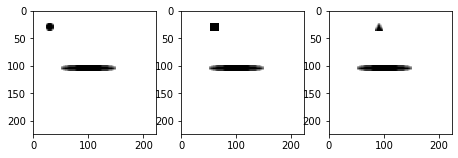

In [48]:
target_size = 15
reference_size = (10, 100)
reference_positions = [(105, 100)]

circle_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
square_patch = matplotlib.patches.Rectangle((-target_size // 2, -target_size // 2), target_size, target_size, color='black')
triangle_patch = matplotlib.patches.RegularPolygon((0, 0), 3, target_size // 2, color='black')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='black')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
different_shapes_gen = PatchStimulusGenerator(target_size, reference_size, 
                                              [circle_patch, square_patch, triangle_patch], 
                                              reference_patch, blur_func=blur_func)

plot_generator_examples(different_shapes_gen)

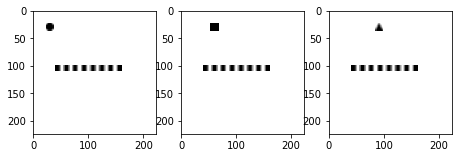

In [45]:
target_size = 15
reference_box_size = 10
total_reference_size = (10, 120)
reference_positions = [(105, 100)]

circle_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
square_patch = matplotlib.patches.Rectangle((-target_size // 2, -target_size // 2), target_size, target_size, color='black')
triangle_patch = matplotlib.patches.RegularPolygon((0, 0), 3, target_size // 2, color='black')

reference_patches = [matplotlib.patches.Rectangle(((-reference_box_size // 2) + (reference_box_size * 2 * i), 
                                                   (-reference_box_size // 2)), 
                                                  reference_box_size, reference_box_size, color='black')
                    for i in range(8)]


blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
split_reference_gen = PatchStimulusGenerator(target_size, total_reference_size, 
                                              [circle_patch, square_patch, triangle_patch], 
                                              reference_patches, blur_func=blur_func,
                                              reference_patch_kwargs=dict(ylim=(-70, 70)))

plot_generator_examples(split_reference_gen)

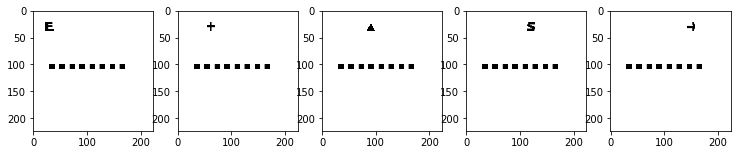

In [52]:
target_size = (15, 15)
reference_box_size = 10
total_reference_size = (10, 140)
reference_positions = [(105, 100)]

triangle_patch = matplotlib.patches.RegularPolygon((0, 0), 3, target_size[0] // 2, color='black')

reference_patches = [matplotlib.patches.Rectangle(((-reference_box_size // 2) + (reference_box_size * 2 * i), 
                                                   (-reference_box_size // 2)), 
                                                  reference_box_size, reference_box_size, color='black')
                    for i in range(8)]


blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
split_reference_text_gen = PatchStimulusGenerator(target_size, total_reference_size, 
                                              ['E', '$+$', triangle_patch, 's', '$\\to$'], 
                                              reference_patches, # blur_func=blur_func,
                                              reference_patch_kwargs=dict(ylim=(-70, 70)))

plot_generator_examples(split_reference_text_gen)

## Triplet generators

In [50]:
TRIPLET_CACHE_SIZE = 16

class TripletGenerator:
    def __init__(self, stimulus_generator, 
                 two_reference_objects=False, two_targets_between=True, n_target_types=1,
                 transpose=False, vertical_margin=0, horizontal_margin=0, seed=RANDOM_SEED, use_tqdm=False):
        self.stimulus_generator = stimulus_generator
        self.two_reference_objects = two_reference_objects
        self.two_targets_between = two_targets_between
        self.n_target_types = n_target_types
        
        if n_target_types > self.stimulus_generator.n_target_types:
            raise ValueError(f'Expected n_target_types={n_target_types} <= self.stimulus_generator.n_targets={self.stimulus_generator.n_targets}')
        
        self.transpose = transpose
        self.vertical_margin = vertical_margin
        self.horizontal_margin = horizontal_margin
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)
        self.use_tqdm = use_tqdm
        
    @lru_cache(maxsize=TRIPLET_CACHE_SIZE)
    def __call__(self, n=1, normalize=True, seed=None):
        if seed is None:
            seed = self.seed
            
        self.rng = np.random.default_rng(self.seed)
        n_iter = range(n)
        if self.use_tqdm:
            n_iter = tqdm(range(n), desc='Data Generation')
        
        results = [self.generate_single_triplet(normalize=normalize)for _ in n_iter]   
        result_tensor = torch.stack(results)
        
        if self.transpose:
            return result_tensor.permute(0, 1, 2, 4, 3)
        
        return result_tensor
    
    @abstractmethod
    def generate_single_triplet(self, normalize=True):
        pass
    

class EquilateralTripletGenerator(TripletGenerator):
    def __init__(self, stimulus_generator, side_length_endpoints, 
                 target_margin_from_reference_edge=0, pair_above=None,
                 two_reference_objects=False, two_targets_between=True, 
                 n_target_types=1, transpose=False, 
                 vertical_margin=0, horizontal_margin=0, 
                 seed=RANDOM_SEED, use_tqdm=False):
        super(EquilateralTripletGenerator, self).__init__(
            stimulus_generator=stimulus_generator, 
            two_reference_objects=two_reference_objects,
            two_targets_between=two_targets_between, n_target_types=n_target_types,
            transpose=transpose, vertical_margin=vertical_margin,
            horizontal_margin=horizontal_margin, seed=seed, use_tqdm=use_tqdm)
        
        if not hasattr(side_length_endpoints, '__len__'):
            side_length_endpoints = (side_length_endpoints, side_length_endpoints)
            
        self.side_length_endpoints = side_length_endpoints
        self.target_margin_from_reference_edge = target_margin_from_reference_edge
        self.pair_above = pair_above
        
    def generate_single_triplet(self, normalize=True):
        side_length = self.rng.integers(*self.side_length_endpoints)
        height = (3 ** 0.5) * side_length / 2
        half_height = height // 2
        if self.two_reference_objects:
            min_vertical_margin = height + (self.stimulus_generator.reference_size[0] // 2) + 1
        else:
            min_vertical_margin = half_height + (self.stimulus_generator.target_size[0] // 2) + 1

        vertical_margin = max(min_vertical_margin, self.vertical_margin)
        horizontal_margin = max(self.stimulus_generator.reference_size[1] // 2 + 1, self.horizontal_margin)

        reference_center_position = np.array(
            (self.rng.integers(vertical_margin, self.stimulus_generator.canvas_size[0] - vertical_margin),
             self.rng.integers(horizontal_margin, self.stimulus_generator.canvas_size[1] - horizontal_margin)), 
            dtype=np.int)

        target_margin = (self.stimulus_generator.reference_size[1] - self.stimulus_generator.target_size[1]) // 2
        left_target_horizontal_offset = self.rng.integers(-target_margin, target_margin - side_length)
        middle_target_horizontal_offset = left_target_horizontal_offset + side_length // 2
        right_target_horizontal_offset = left_target_horizontal_offset + side_length

        if self.pair_above is None:
            pair_above = np.sign(self.rng.uniform(-0.5, 0.5))
        else:
            pair_above = self.pair_above and 1 or -1

        left_target_offset = np.array((pair_above * half_height, left_target_horizontal_offset), dtype=np.int)
        middle_target_offset = np.array((-1 * pair_above * half_height, middle_target_horizontal_offset), dtype=np.int)
        right_target_offset = np.array((pair_above * half_height, right_target_horizontal_offset), dtype=np.int)

        target_positions = [tuple(reference_center_position + offset) for offset in 
                            (left_target_offset, right_target_offset, middle_target_offset)]

        if self.two_reference_objects:
            second_reference_center = np.copy(reference_center_position)
            two_targets_between = self.two_targets_between and 1 or -1
            second_reference_vertical_direction = pair_above * two_targets_between
            second_reference_center[0] += second_reference_vertical_direction * height
            reference_center_position = [reference_center_position, second_reference_center]
            
        if self.n_target_types == 1:
            target_indices = (self.rng.integers(0, self.stimulus_generator.n_target_types), ) * 3
        if self.n_target_types == 2:
            pair_color = self.rng.uniform() > 0.5
            single_color = 1 - pair_color
            if self.rng.uniform() > 0.5:
                target_indices = (pair_color, single_color, pair_color)
            else:
                target_indices = (single_color, pair_color, pair_color)
        elif self.n_target_types == 3:
            target_indices = [0, 1, 2]
            self.rng.shuffle(target_indices)
            target_indices = tuple(target_indices)
            
#         if second_reference_center[0] <= (self.stimulus_generator.reference_size[0] // 2) or \
#             second_reference_center[0] >= (223 - (self.stimulus_generator.reference_size[0] // 2)) or \
#             second_reference_center[1] <= (self.stimulus_generator.reference_size[1] // 2) or \
#             second_reference_center[0] >= (223 - (self.stimulus_generator.reference_size[0] // 2)):
            
#             print(reference_center_position)
#             print(side_length, height, half_height, horizontal_margin, vertical_margin)
        
        return self.stimulus_generator.batch_generate(target_positions, reference_center_position, target_indices, normalize=normalize)
    
    
class QuinnTripletGenerator(TripletGenerator):
    def __init__(self, stimulus_generator, distance_endpoints, 
                 target_margin_from_reference_edge=0, pair_above=None, two_objects_left=None,
                 two_reference_objects=False, two_targets_between=True, 
                 n_target_types=1, transpose=False,
                 vertical_margin=0, horizontal_margin=0,
                 seed=RANDOM_SEED, use_tqdm=False):
        super(QuinnTripletGenerator, self).__init__(
            stimulus_generator=stimulus_generator, 
            two_reference_objects=two_reference_objects,
            two_targets_between=two_targets_between, n_target_types=n_target_types,
            transpose=transpose, vertical_margin=vertical_margin, 
            horizontal_margin=horizontal_margin, seed=seed, use_tqdm=use_tqdm)
        
        if not hasattr(distance_endpoints, '__len__'):
            distance_endpoints = (distance_endpoints, distance_endpoints)
            
        self.distance_endpoints = distance_endpoints        
        self.target_margin_from_reference_edge = target_margin_from_reference_edge
        self.pair_above = pair_above
        self.two_objects_left = two_objects_left
    
    def generate_single_triplet(self, normalize=True):
        distance = self.rng.integers(*self.distance_endpoints)
        half_distance = distance // 2
        if self.two_reference_objects:
            min_vertical_margin = distance + (self.stimulus_generator.reference_size[0] // 2) + 1
        else:
            min_vertical_margin = half_distance + (self.stimulus_generator.target_size[0] // 2) + 1

        vertical_margin = max(min_vertical_margin, self.vertical_margin)
        horizontal_margin = max(self.stimulus_generator.reference_size[1] // 2 + 1, self.horizontal_margin)

        reference_center_position = np.array(
            (self.rng.integers(vertical_margin, self.stimulus_generator.canvas_size[0] - vertical_margin),
             self.rng.integers(horizontal_margin, self.stimulus_generator.canvas_size[1] - horizontal_margin)), 
            dtype=np.int)

        target_margin = (self.stimulus_generator.reference_size[1] - self.stimulus_generator.target_size[1]) // 2
        left_target_horizontal_offset = self.rng.integers(-target_margin, target_margin - distance)
        right_target_horizontal_offset = left_target_horizontal_offset + distance

        if self.pair_above is None:
            pair_above = np.sign(self.rng.uniform(-0.5, 0.5))
        else:
            pair_above = self.pair_above and 1 or -1

        two_objects_left = self.two_objects_left
        if two_objects_left is None:
            two_objects_left = self.rng.uniform() > 0.5

        left_target_offset = np.array((pair_above * half_distance, left_target_horizontal_offset), dtype=np.int)
        right_target_offset = np.array((pair_above * half_distance, right_target_horizontal_offset), dtype=np.int)
        other_side_target_offset = np.array((-pair_above * half_distance, two_objects_left and left_target_horizontal_offset or right_target_horizontal_offset), dtype=np.int)

        if two_objects_left:
            target_offsets = (left_target_offset, right_target_offset, other_side_target_offset)
        else: 
            target_offsets = (right_target_offset, left_target_offset, other_side_target_offset)
            
        target_positions = [tuple(reference_center_position + offset) for offset in target_offsets]

        if self.two_reference_objects:
            second_reference_center = np.copy(reference_center_position)
            two_targets_between = self.two_targets_between and 1 or -1
            second_reference_vertical_direction = pair_above * two_targets_between
            second_reference_center[0] += second_reference_vertical_direction * distance
            reference_center_position = [reference_center_position, second_reference_center]
            
        if self.n_target_types == 1:
            target_indices = (self.rng.integers(0, self.stimulus_generator.n_target_types), ) * 3
        if self.n_target_types == 2:
            pair_color, single_color = self.rng.choice(np.arange(self.stimulus_generator.n_target_types),
                                                       size=2, replace=False)
#             pair_color = self.rng.uniform() > 0.5
#             single_color = 1 - pair_color
            target_indices = (single_color, pair_color, pair_color)
            
        elif self.n_target_types == 3:
            target_indices = [0, 1, 2]
            self.rng.shuffle(target_indices)
            target_indices = tuple(target_indices)

        return self.stimulus_generator.batch_generate(target_positions, reference_center_position, target_indices, normalize=normalize)


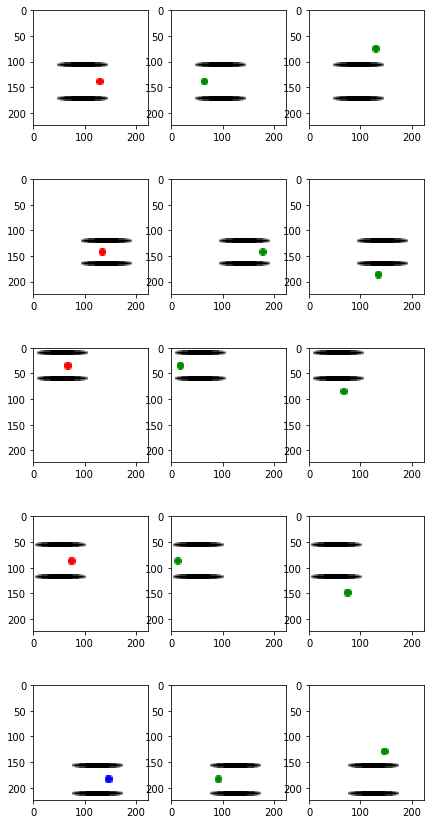

In [51]:
N = 5

above_below_quinn_gen = QuinnTripletGenerator(gen, (30, 70), two_reference_objects=True, n_target_types=2)
results = above_below_quinn_gen(N, normalize=False)
plt.figure(figsize=(7, 3 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        ax.imshow(results[row, col].permute(1, 2, 0).numpy())

plt.show()


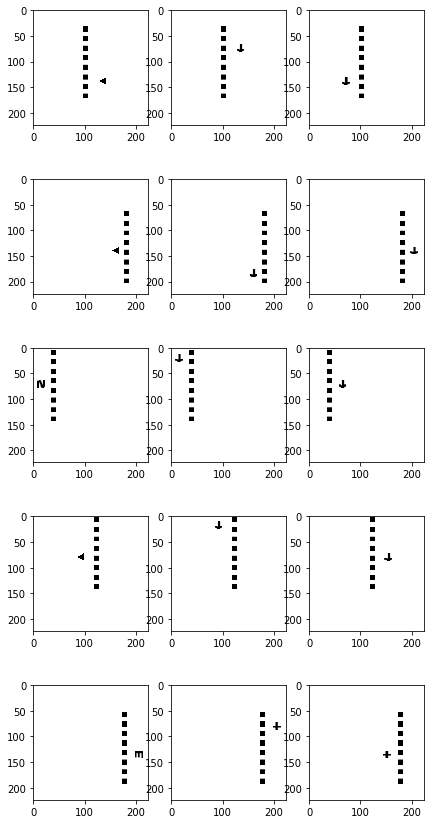

In [153]:
N = 5

above_below_quinn_gen = QuinnTripletGenerator(split_reference_text_gen, (30, 70), 
                                              two_reference_objects=False, 
                                              n_target_types=2, transpose=True)
results = above_below_quinn_gen(N, normalize=False)
plt.figure(figsize=(7, 3 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        ax.imshow(results[row, col].permute(1, 2, 0).numpy())

plt.show()


## Metric functions

In [54]:
class Metric:
    def __init__(self, name, correct_index=0):
        self.name = name
        self.correct_index = correct_index
        
    @abstractmethod
    def __call__(self, pairwise_cosines):
        pass
    
    def aggregate(self, result_list):
        if isinstance(result_list[0], torch.Tensor):
            return torch.cat(result_list).detach().cpu().numpy()
        
        if isinstance(result_list[0], np.ndarray):
            return np.concatenate(result_list)
        
        raise ValueError(f'Can only combine lists of torch.Tensor or np.ndarray, received {type(result_list[0])}')

        
class AccuracyMetric(Metric):
    def __init__(self, name, correct_index=0, pair_only=False, pair_comparison_index=1):
        super(AccuracyMetric, self).__init__(name, correct_index)
        self.pair_only = pair_only
        self.pair_comparison_index = pair_comparison_index
        
    def __call__(self, pairwise_cosines):
        if self.pair_only:
            comp = pairwise_cosines[:, self.correct_index] > pairwise_cosines[:, self.pair_comparison_index]
        else:
            comp = pairwise_cosines.argmax(dim=1) == self.correct_index

        return comp.to(torch.float)
        
        
class DifferenceMetric(Metric):
    def __init__(self, name, correct_index=0, combine_func=torch.mean,
                 combine_func_kwargs=dict(dim=1)):
        super(DifferenceMetric, self).__init__(name, correct_index)
        self.combine_func = combine_func
        self.incorrect_indices = list(range(3))
        self.incorrect_indices.remove(correct_index)
        self.combine_func_kwargs = combine_func_kwargs
        
    def __call__(self, pairwise_cosines):
        return pairwise_cosines[:, self.correct_index] - self.combine_func(pairwise_cosines[:, self.incorrect_indices], **self.combine_func_kwargs)
    
    
class PairDifferenceMetric(Metric):
    def __init__(self, name, correct_index=0, pair_comparison_index=1):
        super(PairDifferenceMetric, self).__init__(name, correct_index)
        self.pair_comparison_index = pair_comparison_index
        
    def __call__(self, pairwise_cosines):
        return pairwise_cosines[:, self.correct_index] - pairwise_cosines[:, self.pair_comparison_index]
    
    
METRICS = (AccuracyMetric('Accuracy', pair_only=True), 
#            AccuracyMetric('Accuracy(Triplet)'),
           PairDifferenceMetric('Difference'),
#            DifferenceMetric('MeanDiff'),
#            DifferenceMetric('MaxDiff', combine_func=lambda x: torch.max(x, dim=1).values, combine_func_kwargs={})
          )

## Actual task implementation

In [55]:
TaskResults = namedtuple('TaskResults', ('mean', 'std', 'n'))

BATCH_SIZE = 64

def quinn_embedding_task_single_generator(
    model, triplet_generator, metrics=METRICS, N=1024, batch_size=BATCH_SIZE, use_tqdm=False):
    
    data = triplet_generator(N)
    B = batch_size
    dataloader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=False)
    
    model_results = defaultdict(list)
    cos = nn.CosineSimilarity(dim=-1)
    triangle_indices = np.triu_indices(3, 1)
    
    model.eval()
    
    data_iter = dataloader
    if use_tqdm:
        data_iter = tqdm(dataloader, desc='Batches')
        
    for b in data_iter:
        x = b[0]  # shape (B, 3, 3, 224, 224)
        x = x.view(-1, *x.shape[2:])
        e = model(x.to(device)).detach().cpu()
        e = e.view(B, 3, -1)  # shape (B, 3, Z)

        embedding_pairwise_cosine = cos(e[:, :, None, :], e[:, None, :, :])  # shape (B, 3, 3)
        triplet_cosines = embedding_pairwise_cosine[:, triangle_indices[0], triangle_indices[1]] # shape (B, 3)

        for metric in metrics:
            model_results[metric.name].append(metric(triplet_cosines))

    for metric in metrics:
        model_results[metric.name] = metric.aggregate(model_results[metric.name])

    return model_results

def quinn_embedding_task_multiple_generators(
    model_name, model, condition_names, triplet_generators, 
    metrics=METRICS, N=1024, batch_size=BATCH_SIZE):
    
    headers = ['ConditionNames'] + [metric.name for metric in metrics]
    all_results = {}
    for name, triplet_gen in zip(condition_names, triplet_generators):
        results = quinn_embedding_task_single_generator(model, triplet_gen, metrics=metrics,
                                                        N=N, batch_size=batch_size)
        all_results[name] = {metric.name: TaskResults(np.mean(results[metric.name]), 
                                                      np.std(results[metric.name]), N) 
                             for metric in metrics}
    return all_results
    

In [116]:
def run_multiple_models_multiple_generators(model_names, model_kwarg_dicts, 
                                            condition_names, condition_generators, N):
    all_model_results = {}
    
    for name, model_kwargs in zip (model_names, model_kwarg_dicts):
        print(f'Starting model {name}')
        model = build_model(**model_kwargs)

        all_model_results[name] = quinn_embedding_task_multiple_generators(
            name, model, condition_names, condition_generators, N=N)

        del model
        
    return all_model_results


def format_results(task_results, print_std=True):
    if print_std:
        return f'${task_results.mean:.4f} \\pm {task_results.std / (task_results.n ** 0.5):.4f}$'
    else:
        return f'${task_results.mean:.4f}$'


def format_replication_results(task_result_lists, print_std=True):
    result_means = np.array([tr.mean for tr in task_result_lists])
    if print_std:
        return f'${result_means.mean():.4f} \\pm {result_means.std() / (len(result_means) ** 0.5):.4f}$'
    else:
        return f'${result_means.mean():.4f}$'

def display_multiple_model_results_single_type(group_name, results, tablefmt='github'):
    display(Markdown(f'## {group_name} Results'))
        
    metric_names = tuple(next(iter(next(iter(results.values())).values())).keys())
    headers = ['Model'] + [name + '&nbsp; ' * 12 for name in metric_names]
    
    for key in next(iter(results.values())).keys():
        display(Markdown(f'### {key}'))
        rows = []
        for model_name, model_results in results.items():
            rows.append([model_name] + [format_results(model_results[key][metric_name])
                                                  for metric_name in metric_names])

        display(Markdown(tabulate.tabulate(rows, headers, tablefmt=tablefmt)))


def display_multiple_model_results_multiple_types(group_name, results, tablefmt='github'):
    display(Markdown(f'## {group_name} Results'))
        
    key_groups = set([key[:-8] for key in next(iter(results.values())).keys()])
    metric_names = tuple(next(iter(next(iter(results.values())).values())).keys())
    headers = ['# Target Types', 'Model'] + [name + '&nbsp; ' * 12 for name in metric_names]
    
    for key_group in key_groups:
        display(Markdown(f'### {key_group}'))
        
        rows = []
        
        for n_types in range(1, 4):
            key = f'{key_group}-{n_types}-types'
            for model_name, model_results in results.items():
                rows.append([n_types, model_name] + [format_results(model_results[key][metric_name])
                                                      for metric_name in metric_names])
                
        display(Markdown(tabulate.tabulate(rows, headers, tablefmt=tablefmt)))

        
def display_multiple_model_results_multiple_types_replications(group_name, result_replications, tablefmt='github'):
    display(Markdown(f'## {group_name} Results'))
    
    ex_results = result_replications[0]
    key_groups = set([key[:-8] for key in next(iter(ex_results.values())).keys()])
    metric_names = tuple(next(iter(next(iter(ex_results.values())).values())).keys())
    headers = ['# Target Types', 'Model'] + [name + '&nbsp; ' * 12 for name in metric_names]
    
    for key_group in key_groups:
        display(Markdown(f'### {key_group}'))
        
        rows = []
        
        for n_types in range(1, 4):
            key = f'{key_group}-{n_types}-types'
            for model_name in ex_results:
                rows.append([n_types, model_name] + \
                            [format_replication_results([replication[model_name][key][metric_name] 
                                                         for replication in result_replications])
                                                      for metric_name in metric_names])
                
        display(Markdown(tabulate.tabulate(rows, headers, tablefmt=tablefmt)))
        

In [57]:
def default_name_func(generator_kwargs, base_name=''):
    two_reference_objects = generator_kwargs['two_reference_objects']
    transpose = generator_kwargs['transpose']
    
    if two_reference_objects:
        if transpose:
            rel_name = 'VerticalBetween'
        else:
            rel_name = 'Between'
    else:
        if transpose:
            rel_name = 'Left/Right'
        else:
            rel_name = 'Above/Below'
    
    name = f'{base_name}{base_name and "-" or ""}{rel_name}'
            
    n_target_types = None
    if 'n_target_types' in generator_kwargs:
        n_target_types = generator_kwargs['n_target_types']
        return name + f'-{n_target_types}-types'
    
    return name


def create_generators_and_names(triplet_generator_class, stimulus_generator, kwarg_value_sets, 
                                name_func=default_name_func, name_func_kwargs=None):
    if name_func_kwargs is None:
        name_func_kwargs = {}
    
    names = []
    triplet_generators = []

    for value_set in itertools.product(*kwarg_value_sets.values()):
        kwargs = {k: v for (k, v) in zip(kwarg_value_sets.keys(), value_set)}
        names.append(name_func(kwargs, **name_func_kwargs))
        triplet_generators.append(triplet_generator_class(stimulus_generator, **kwargs))

    return names, triplet_generators
    

In [58]:
QUINN_DISTANCE_ENDPOINTS = (30, 70)

quinn_default_value_sets = dict(
    distance_endpoints=(QUINN_DISTANCE_ENDPOINTS,),
    two_reference_objects=(False, True),
    transpose=(False, True),
    n_target_types=range(1, 4)
)

quinn_names, quinn_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn'))

In [59]:
model_kwarg_dicts = (
    dict(name=MOBILENET, device=device, pretrained=False, saycam='SAY'),
    dict(name=MOBILENET, device=device, pretrained=True),
    dict(name=MOBILENET, device=device, pretrained=False),
    dict(name=RESNEXT, device=device, pretrained=False, saycam='SAY'),
    dict(name=RESNEXT, device=device, pretrained=True),
    dict(name=RESNEXT, device=device, pretrained=False),
)

model_names = [ f'{d["name"]}-{"saycam" in d and "saycam" or (d["pretrained"] and "imagenet" or "random")}'
               for d in model_kwarg_dicts]


In [60]:
N = 1024
quinn_generators_all_model_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_names, quinn_triplet_generators, N)

Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random


In [61]:
display_multiple_model_results_multiple_types('Quinn', quinn_generators_all_model_results, tablefmt='github')

## Quinn Results

### Quinn-Between-sideways

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.5645 \pm 0.0155$                                                                            | $0.0010 \pm 0.0004$                                                                              |
|                1 | mobilenet-imagenet | $0.3936 \pm 0.0153$                                                                            | $-0.0033 \pm 0.0004$                                                                             |
|                1 | mobilenet-random   | $0.3984 \pm 0.0153$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.2783 \pm 0.0140$                                                                            | $-0.0092 \pm 0.0005$                                                                             |
|                1 | resnext-imagenet   | $0.0938 \pm 0.0091$                                                                            | $-0.0265 \pm 0.0007$                                                                             |
|                1 | resnext-random     | $0.5322 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.6260 \pm 0.0151$                                                                            | $0.0030 \pm 0.0004$                                                                              |
|                2 | mobilenet-imagenet | $0.4248 \pm 0.0154$                                                                            | $-0.0028 \pm 0.0006$                                                                             |
|                2 | mobilenet-random   | $0.3955 \pm 0.0153$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.2871 \pm 0.0141$                                                                            | $-0.0092 \pm 0.0005$                                                                             |
|                2 | resnext-imagenet   | $0.1123 \pm 0.0099$                                                                            | $-0.0311 \pm 0.0008$                                                                             |
|                2 | resnext-random     | $0.5586 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.6270 \pm 0.0151$                                                                            | $0.0032 \pm 0.0004$                                                                              |
|                3 | mobilenet-imagenet | $0.4521 \pm 0.0156$                                                                            | $-0.0024 \pm 0.0007$                                                                             |
|                3 | mobilenet-random   | $0.4355 \pm 0.0155$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.3223 \pm 0.0146$                                                                            | $-0.0081 \pm 0.0005$                                                                             |
|                3 | resnext-imagenet   | $0.1719 \pm 0.0118$                                                                            | $-0.0316 \pm 0.0010$                                                                             |
|                3 | resnext-random     | $0.5498 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Between

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.9873 \pm 0.0035$                                                                            | $0.0305 \pm 0.0004$                                                                              |
|                1 | mobilenet-imagenet | $0.9004 \pm 0.0094$                                                                            | $0.0225 \pm 0.0006$                                                                              |
|                1 | mobilenet-random   | $0.4512 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.9541 \pm 0.0065$                                                                            | $0.0349 \pm 0.0007$                                                                              |
|                1 | resnext-imagenet   | $0.6738 \pm 0.0147$                                                                            | $0.0068 \pm 0.0006$                                                                              |
|                1 | resnext-random     | $0.4980 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | mobilenet-saycam   | $0.9736 \pm 0.0050$                                                                            | $0.0297 \pm 0.0005$                                                                              |
|                2 | mobilenet-imagenet | $0.8057 \pm 0.0124$                                                                            | $0.0187 \pm 0.0007$                                                                              |
|                2 | mobilenet-random   | $0.4268 \pm 0.0155$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.9346 \pm 0.0077$                                                                            | $0.0333 \pm 0.0007$                                                                              |
|                2 | resnext-imagenet   | $0.4434 \pm 0.0155$                                                                            | $-0.0034 \pm 0.0010$                                                                             |
|                2 | resnext-random     | $0.5322 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.9775 \pm 0.0046$                                                                            | $0.0295 \pm 0.0005$                                                                              |
|                3 | mobilenet-imagenet | $0.7734 \pm 0.0131$                                                                            | $0.0203 \pm 0.0008$                                                                              |
|                3 | mobilenet-random   | $0.4248 \pm 0.0154$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.9443 \pm 0.0072$                                                                            | $0.0338 \pm 0.0007$                                                                              |
|                3 | resnext-imagenet   | $0.4629 \pm 0.0156$                                                                            | $-0.0041 \pm 0.0009$                                                                             |
|                3 | resnext-random     | $0.5303 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Above/Below

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $1.0000 \pm 0.0000$                                                                            | $0.0773 \pm 0.0007$                                                                              |
|                1 | mobilenet-imagenet | $0.9346 \pm 0.0077$                                                                            | $0.0420 \pm 0.0008$                                                                              |
|                1 | mobilenet-random   | $0.5156 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.1140 \pm 0.0010$                                                                              |
|                1 | resnext-imagenet   | $0.8916 \pm 0.0097$                                                                            | $0.0332 \pm 0.0010$                                                                              |
|                1 | resnext-random     | $0.5830 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.9961 \pm 0.0019$                                                                            | $0.0712 \pm 0.0007$                                                                              |
|                2 | mobilenet-imagenet | $0.8213 \pm 0.0120$                                                                            | $0.0322 \pm 0.0011$                                                                              |
|                2 | mobilenet-random   | $0.4961 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.1097 \pm 0.0010$                                                                              |
|                2 | resnext-imagenet   | $0.7021 \pm 0.0143$                                                                            | $0.0185 \pm 0.0014$                                                                              |
|                2 | resnext-random     | $0.5713 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.9980 \pm 0.0014$                                                                            | $0.0710 \pm 0.0008$                                                                              |
|                3 | mobilenet-imagenet | $0.8271 \pm 0.0118$                                                                            | $0.0352 \pm 0.0011$                                                                              |
|                3 | mobilenet-random   | $0.4922 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.1110 \pm 0.0010$                                                                              |
|                3 | resnext-imagenet   | $0.6914 \pm 0.0144$                                                                            | $0.0183 \pm 0.0013$                                                                              |
|                3 | resnext-random     | $0.5420 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Left/Right

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.6094 \pm 0.0152$                                                                            | $0.0027 \pm 0.0005$                                                                              |
|                1 | mobilenet-imagenet | $0.3291 \pm 0.0147$                                                                            | $-0.0066 \pm 0.0005$                                                                             |
|                1 | mobilenet-random   | $0.5059 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.0488 \pm 0.0067$                                                                            | $-0.0219 \pm 0.0004$                                                                             |
|                1 | resnext-imagenet   | $0.1543 \pm 0.0113$                                                                            | $-0.0231 \pm 0.0007$                                                                             |
|                1 | resnext-random     | $0.6152 \pm 0.0152$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.6045 \pm 0.0153$                                                                            | $0.0035 \pm 0.0005$                                                                              |
|                2 | mobilenet-imagenet | $0.3936 \pm 0.0153$                                                                            | $-0.0054 \pm 0.0008$                                                                             |
|                2 | mobilenet-random   | $0.5078 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.0615 \pm 0.0075$                                                                            | $-0.0211 \pm 0.0005$                                                                             |
|                2 | resnext-imagenet   | $0.2637 \pm 0.0138$                                                                            | $-0.0197 \pm 0.0011$                                                                             |
|                2 | resnext-random     | $0.5742 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.5830 \pm 0.0154$                                                                            | $0.0030 \pm 0.0006$                                                                              |
|                3 | mobilenet-imagenet | $0.4492 \pm 0.0155$                                                                            | $-0.0051 \pm 0.0009$                                                                             |
|                3 | mobilenet-random   | $0.5010 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.0918 \pm 0.0090$                                                                            | $-0.0208 \pm 0.0005$                                                                             |
|                3 | resnext-imagenet   | $0.3242 \pm 0.0146$                                                                            | $-0.0189 \pm 0.0012$                                                                             |
|                3 | resnext-random     | $0.5625 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |

In [62]:
quinn_single_color_value_sets = dict(
    distance_endpoints=(QUINN_DISTANCE_ENDPOINTS,),
    two_reference_objects=(False, True),
    transpose=(False, True),
)

quinn_single_color_names, quinn_single_color_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, same_color_gen, quinn_single_color_value_sets, name_func_kwargs=dict(base_name='Quinn-Single-Color'))


In [63]:
N = 1024
quinn_generators_single_color_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_single_color_names, quinn_single_color_triplet_generators, N)

Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random


In [64]:
display_multiple_model_results_single_type('Quinn Single Color', quinn_generators_single_color_results, tablefmt='github')

## Quinn Single Color Results

### Quinn-Single-Color-Above/Below

| Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| mobilenet-saycam   | $1.0000 \pm 0.0000$                                                                            | $0.0707 \pm 0.0007$                                                                              |
| mobilenet-imagenet | $0.9229 \pm 0.0083$                                                                            | $0.0318 \pm 0.0007$                                                                              |
| mobilenet-random   | $0.5049 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
| resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.0930 \pm 0.0009$                                                                              |
| resnext-imagenet   | $0.8867 \pm 0.0099$                                                                            | $0.0427 \pm 0.0012$                                                                              |
| resnext-random     | $0.6172 \pm 0.0152$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Single-Color-Left/Right

| Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| mobilenet-saycam   | $0.5137 \pm 0.0156$                                                                            | $0.0008 \pm 0.0006$                                                                              |
| mobilenet-imagenet | $0.2139 \pm 0.0128$                                                                            | $-0.0145 \pm 0.0006$                                                                             |
| mobilenet-random   | $0.5068 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
| resnext-saycam     | $0.0508 \pm 0.0069$                                                                            | $-0.0204 \pm 0.0004$                                                                             |
| resnext-imagenet   | $0.1260 \pm 0.0104$                                                                            | $-0.0273 \pm 0.0008$                                                                             |
| resnext-random     | $0.5986 \pm 0.0153$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Single-Color-Between

| Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| mobilenet-saycam   | $0.9844 \pm 0.0039$                                                                            | $0.0341 \pm 0.0005$                                                                              |
| mobilenet-imagenet | $0.9033 \pm 0.0092$                                                                            | $0.0213 \pm 0.0006$                                                                              |
| mobilenet-random   | $0.5117 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
| resnext-saycam     | $0.9492 \pm 0.0069$                                                                            | $0.0348 \pm 0.0007$                                                                              |
| resnext-imagenet   | $0.6260 \pm 0.0151$                                                                            | $0.0048 \pm 0.0008$                                                                              |
| resnext-random     | $0.5117 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Single-Color-Between-sideways

| Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| mobilenet-saycam   | $0.6934 \pm 0.0144$                                                                            | $0.0057 \pm 0.0004$                                                                              |
| mobilenet-imagenet | $0.2754 \pm 0.0140$                                                                            | $-0.0094 \pm 0.0006$                                                                             |
| mobilenet-random   | $0.4961 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
| resnext-saycam     | $0.2646 \pm 0.0138$                                                                            | $-0.0106 \pm 0.0005$                                                                             |
| resnext-imagenet   | $0.1387 \pm 0.0108$                                                                            | $-0.0238 \pm 0.0007$                                                                             |
| resnext-random     | $0.5059 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

In [65]:
quinn_different_shape_names, quinn_different_shape_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, different_shapes_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Diff-Shapes'))

In [66]:
N = 1024
quinn_generators_different_shapes_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_different_shape_names, quinn_different_shape_triplet_generators, N)

Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random


In [67]:
display_multiple_model_results_multiple_types('Quinn Different Shapes', quinn_generators_different_shapes_results, tablefmt='github')

## Quinn Different Shapes Results

### Quinn-Diff-Shapes-Between-sideways

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.6367 \pm 0.0150$                                                                            | $0.0034 \pm 0.0004$                                                                              |
|                1 | mobilenet-imagenet | $0.3115 \pm 0.0145$                                                                            | $-0.0063 \pm 0.0005$                                                                             |
|                1 | mobilenet-random   | $0.5430 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam     | $0.2637 \pm 0.0138$                                                                            | $-0.0101 \pm 0.0005$                                                                             |
|                1 | resnext-imagenet   | $0.1299 \pm 0.0105$                                                                            | $-0.0209 \pm 0.0006$                                                                             |
|                1 | resnext-random     | $0.5088 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.6543 \pm 0.0149$                                                                            | $0.0052 \pm 0.0005$                                                                              |
|                2 | mobilenet-imagenet | $0.3252 \pm 0.0146$                                                                            | $-0.0089 \pm 0.0007$                                                                             |
|                2 | mobilenet-random   | $0.5137 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam     | $0.5107 \pm 0.0156$                                                                            | $-0.0014 \pm 0.0011$                                                                             |
|                2 | resnext-imagenet   | $0.1758 \pm 0.0119$                                                                            | $-0.0228 \pm 0.0008$                                                                             |
|                2 | resnext-random     | $0.5303 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.6396 \pm 0.0150$                                                                            | $0.0052 \pm 0.0005$                                                                              |
|                3 | mobilenet-imagenet | $0.3975 \pm 0.0153$                                                                            | $-0.0077 \pm 0.0010$                                                                             |
|                3 | mobilenet-random   | $0.5293 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam     | $0.5811 \pm 0.0154$                                                                            | $0.0117 \pm 0.0133$                                                                              |
|                3 | resnext-imagenet   | $0.1748 \pm 0.0119$                                                                            | $-0.0244 \pm 0.0010$                                                                             |
|                3 | resnext-random     | $0.5000 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

### Quinn-Diff-Shapes-Between

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.9785 \pm 0.0045$                                                                            | $0.0269 \pm 0.0005$                                                                              |
|                1 | mobilenet-imagenet | $0.8408 \pm 0.0114$                                                                            | $0.0179 \pm 0.0006$                                                                              |
|                1 | mobilenet-random   | $0.6025 \pm 0.0153$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam     | $0.8896 \pm 0.0098$                                                                            | $0.0277 \pm 0.0008$                                                                              |
|                1 | resnext-imagenet   | $0.6631 \pm 0.0148$                                                                            | $0.0055 \pm 0.0007$                                                                              |
|                1 | resnext-random     | $0.5283 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.9453 \pm 0.0071$                                                                            | $0.0251 \pm 0.0006$                                                                              |
|                2 | mobilenet-imagenet | $0.6562 \pm 0.0148$                                                                            | $0.0096 \pm 0.0008$                                                                              |
|                2 | mobilenet-random   | $0.6016 \pm 0.0153$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam     | $0.6885 \pm 0.0145$                                                                            | $0.0101 \pm 0.0011$                                                                              |
|                2 | resnext-imagenet   | $0.5117 \pm 0.0156$                                                                            | $-0.0006 \pm 0.0008$                                                                             |
|                2 | resnext-random     | $0.5566 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.9131 \pm 0.0088$                                                                            | $0.0253 \pm 0.0006$                                                                              |
|                3 | mobilenet-imagenet | $0.6025 \pm 0.0153$                                                                            | $0.0099 \pm 0.0009$                                                                              |
|                3 | mobilenet-random   | $0.5684 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam     | $0.5869 \pm 0.0154$                                                                            | $0.0229 \pm 0.0128$                                                                              |
|                3 | resnext-imagenet   | $0.5166 \pm 0.0156$                                                                            | $-0.0016 \pm 0.0009$                                                                             |
|                3 | resnext-random     | $0.5254 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Diff-Shapes-Above/Below

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.9990 \pm 0.0010$                                                                            | $0.0665 \pm 0.0007$                                                                              |
|                1 | mobilenet-imagenet | $0.9355 \pm 0.0077$                                                                            | $0.0407 \pm 0.0009$                                                                              |
|                1 | mobilenet-random   | $0.5098 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam     | $0.9355 \pm 0.0077$                                                                            | $0.0798 \pm 0.0017$                                                                              |
|                1 | resnext-imagenet   | $0.8770 \pm 0.0103$                                                                            | $0.0375 \pm 0.0011$                                                                              |
|                1 | resnext-random     | $0.6387 \pm 0.0150$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.9814 \pm 0.0042$                                                                            | $0.0529 \pm 0.0008$                                                                              |
|                2 | mobilenet-imagenet | $0.7061 \pm 0.0142$                                                                            | $0.0189 \pm 0.0012$                                                                              |
|                2 | mobilenet-random   | $0.5137 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam     | $0.6611 \pm 0.0148$                                                                            | $0.0337 \pm 0.0018$                                                                              |
|                2 | resnext-imagenet   | $0.6416 \pm 0.0150$                                                                            | $0.0134 \pm 0.0013$                                                                              |
|                2 | resnext-random     | $0.5771 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.9727 \pm 0.0051$                                                                            | $0.0532 \pm 0.0008$                                                                              |
|                3 | mobilenet-imagenet | $0.6436 \pm 0.0150$                                                                            | $0.0193 \pm 0.0016$                                                                              |
|                3 | mobilenet-random   | $0.5088 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam     | $0.5039 \pm 0.0156$                                                                            | $0.0415 \pm 0.0113$                                                                              |
|                3 | resnext-imagenet   | $0.6416 \pm 0.0150$                                                                            | $0.0151 \pm 0.0014$                                                                              |
|                3 | resnext-random     | $0.5088 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Diff-Shapes-Left/Right

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.6123 \pm 0.0152$                                                                            | $0.0036 \pm 0.0005$                                                                              |
|                1 | mobilenet-imagenet | $0.2705 \pm 0.0139$                                                                            | $-0.0106 \pm 0.0006$                                                                             |
|                1 | mobilenet-random   | $0.5020 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam     | $0.1865 \pm 0.0122$                                                                            | $-0.0141 \pm 0.0006$                                                                             |
|                1 | resnext-imagenet   | $0.1123 \pm 0.0099$                                                                            | $-0.0302 \pm 0.0009$                                                                             |
|                1 | resnext-random     | $0.6045 \pm 0.0153$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.4912 \pm 0.0156$                                                                            | $-0.0003 \pm 0.0006$                                                                             |
|                2 | mobilenet-imagenet | $0.3936 \pm 0.0153$                                                                            | $-0.0100 \pm 0.0013$                                                                             |
|                2 | mobilenet-random   | $0.5098 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam     | $0.3896 \pm 0.0152$                                                                            | $-0.0071 \pm 0.0012$                                                                             |
|                2 | resnext-imagenet   | $0.2197 \pm 0.0129$                                                                            | $-0.0266 \pm 0.0011$                                                                             |
|                2 | resnext-random     | $0.5273 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.5205 \pm 0.0156$                                                                            | $-0.0001 \pm 0.0006$                                                                             |
|                3 | mobilenet-imagenet | $0.4668 \pm 0.0156$                                                                            | $-0.0090 \pm 0.0019$                                                                             |
|                3 | mobilenet-random   | $0.5107 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam     | $0.4971 \pm 0.0156$                                                                            | $0.0036 \pm 0.0131$                                                                              |
|                3 | resnext-imagenet   | $0.2334 \pm 0.0132$                                                                            | $-0.0276 \pm 0.0012$                                                                             |
|                3 | resnext-random     | $0.4863 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

In [68]:
quinn_split_reference_names, quinn_split_reference_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, split_reference_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Split-Reference'))

In [69]:
N = 1024
quinn_generators_split_reference_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_split_reference_names, quinn_split_reference_triplet_generators, N)

Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random


In [70]:
display_multiple_model_results_multiple_types('Quinn Split Reference', quinn_generators_split_reference_results, tablefmt='github')

## Quinn Split Reference Results

### Quinn-Split-Reference-Above/Below

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.9990 \pm 0.0010$                                                                            | $0.0451 \pm 0.0006$                                                                              |
|                1 | mobilenet-imagenet | $0.9609 \pm 0.0061$                                                                            | $0.0528 \pm 0.0011$                                                                              |
|                1 | mobilenet-random   | $0.5137 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam     | $0.9541 \pm 0.0065$                                                                            | $0.0364 \pm 0.0007$                                                                              |
|                1 | resnext-imagenet   | $0.9619 \pm 0.0060$                                                                            | $0.0542 \pm 0.0011$                                                                              |
|                1 | resnext-random     | $0.6953 \pm 0.0144$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.9805 \pm 0.0043$                                                                            | $0.0364 \pm 0.0007$                                                                              |
|                2 | mobilenet-imagenet | $0.7070 \pm 0.0142$                                                                            | $0.0268 \pm 0.0018$                                                                              |
|                2 | mobilenet-random   | $0.5068 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.6641 \pm 0.0148$                                                                            | $0.0140 \pm 0.0012$                                                                              |
|                2 | resnext-imagenet   | $0.6836 \pm 0.0145$                                                                            | $0.0242 \pm 0.0015$                                                                              |
|                2 | resnext-random     | $0.5791 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.9736 \pm 0.0050$                                                                            | $0.0367 \pm 0.0007$                                                                              |
|                3 | mobilenet-imagenet | $0.6260 \pm 0.0151$                                                                            | $0.0261 \pm 0.0022$                                                                              |
|                3 | mobilenet-random   | $0.5215 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam     | $0.5117 \pm 0.0156$                                                                            | $0.0237 \pm 0.0115$                                                                              |
|                3 | resnext-imagenet   | $0.6465 \pm 0.0149$                                                                            | $0.0244 \pm 0.0017$                                                                              |
|                3 | resnext-random     | $0.5107 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

### Quinn-Split-Reference-Left/Right

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.7754 \pm 0.0130$                                                                            | $0.0062 \pm 0.0003$                                                                              |
|                1 | mobilenet-imagenet | $0.6152 \pm 0.0152$                                                                            | $0.0045 \pm 0.0004$                                                                              |
|                1 | mobilenet-random   | $0.5068 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam     | $0.4238 \pm 0.0154$                                                                            | $-0.0014 \pm 0.0005$                                                                             |
|                1 | resnext-imagenet   | $0.5762 \pm 0.0154$                                                                            | $0.0033 \pm 0.0004$                                                                              |
|                1 | resnext-random     | $0.7041 \pm 0.0143$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.6328 \pm 0.0151$                                                                            | $0.0024 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet | $0.5117 \pm 0.0156$                                                                            | $0.0010 \pm 0.0008$                                                                              |
|                2 | mobilenet-random   | $0.5127 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam     | $0.4590 \pm 0.0156$                                                                            | $-0.0007 \pm 0.0012$                                                                             |
|                2 | resnext-imagenet   | $0.4863 \pm 0.0156$                                                                            | $-0.0004 \pm 0.0008$                                                                             |
|                2 | resnext-random     | $0.5771 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.6328 \pm 0.0151$                                                                            | $0.0026 \pm 0.0004$                                                                              |
|                3 | mobilenet-imagenet | $0.5166 \pm 0.0156$                                                                            | $0.0010 \pm 0.0010$                                                                              |
|                3 | mobilenet-random   | $0.5039 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam     | $0.4990 \pm 0.0156$                                                                            | $0.0075 \pm 0.0111$                                                                              |
|                3 | resnext-imagenet   | $0.5049 \pm 0.0156$                                                                            | $0.0012 \pm 0.0011$                                                                              |
|                3 | resnext-random     | $0.5088 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

### Quinn-Split-Reference-Between-sideways

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.8555 \pm 0.0110$                                                                            | $0.0071 \pm 0.0002$                                                                              |
|                1 | mobilenet-imagenet | $0.6768 \pm 0.0146$                                                                            | $0.0057 \pm 0.0004$                                                                              |
|                1 | mobilenet-random   | $0.4688 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.4424 \pm 0.0155$                                                                            | $-0.0026 \pm 0.0004$                                                                             |
|                1 | resnext-imagenet   | $0.6436 \pm 0.0150$                                                                            | $0.0041 \pm 0.0003$                                                                              |
|                1 | resnext-random     | $0.6582 \pm 0.0148$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.8174 \pm 0.0121$                                                                            | $0.0065 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet | $0.6504 \pm 0.0149$                                                                            | $0.0058 \pm 0.0005$                                                                              |
|                2 | mobilenet-random   | $0.4414 \pm 0.0155$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.5879 \pm 0.0154$                                                                            | $0.0014 \pm 0.0009$                                                                              |
|                2 | resnext-imagenet   | $0.5273 \pm 0.0156$                                                                            | $0.0012 \pm 0.0005$                                                                              |
|                2 | resnext-random     | $0.5869 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.7754 \pm 0.0130$                                                                            | $0.0066 \pm 0.0003$                                                                              |
|                3 | mobilenet-imagenet | $0.6523 \pm 0.0149$                                                                            | $0.0061 \pm 0.0005$                                                                              |
|                3 | mobilenet-random   | $0.4629 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.5576 \pm 0.0155$                                                                            | $0.0114 \pm 0.0111$                                                                              |
|                3 | resnext-imagenet   | $0.5137 \pm 0.0156$                                                                            | $0.0009 \pm 0.0007$                                                                              |
|                3 | resnext-random     | $0.5107 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Split-Reference-Between

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.9648 \pm 0.0058$                                                                            | $0.0144 \pm 0.0003$                                                                              |
|                1 | mobilenet-imagenet | $0.9424 \pm 0.0073$                                                                            | $0.0448 \pm 0.0012$                                                                              |
|                1 | mobilenet-random   | $0.4629 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.9033 \pm 0.0092$                                                                            | $0.0149 \pm 0.0005$                                                                              |
|                1 | resnext-imagenet   | $0.9189 \pm 0.0085$                                                                            | $0.0280 \pm 0.0008$                                                                              |
|                1 | resnext-random     | $0.6387 \pm 0.0150$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.9131 \pm 0.0088$                                                                            | $0.0130 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet | $0.8896 \pm 0.0098$                                                                            | $0.0428 \pm 0.0013$                                                                              |
|                2 | mobilenet-random   | $0.4658 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.6787 \pm 0.0146$                                                                            | $-0.0027 \pm 0.0012$                                                                             |
|                2 | resnext-imagenet   | $0.7871 \pm 0.0128$                                                                            | $0.0226 \pm 0.0010$                                                                              |
|                2 | resnext-random     | $0.5850 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.8730 \pm 0.0104$                                                                            | $0.0122 \pm 0.0004$                                                                              |
|                3 | mobilenet-imagenet | $0.8701 \pm 0.0105$                                                                            | $0.0414 \pm 0.0013$                                                                              |
|                3 | mobilenet-random   | $0.5156 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.5742 \pm 0.0155$                                                                            | $0.0076 \pm 0.0118$                                                                              |
|                3 | resnext-imagenet   | $0.7510 \pm 0.0135$                                                                            | $0.0213 \pm 0.0010$                                                                              |
|                3 | resnext-random     | $0.5127 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

In [93]:
quinn_split_reference_text_names, quinn_split_reference_text_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, split_reference_text_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Split-Reference-Text'))

In [94]:
N = 1024
quinn_generators_split_reference_text_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_split_reference_text_names, quinn_split_reference_text_triplet_generators, N)

Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random


In [95]:
display_multiple_model_results_multiple_types('Quinn Split Reference Text Target', quinn_generators_split_reference_text_results, tablefmt='github')

## Quinn Split Reference Text Target Results

### Quinn-Split-Reference-Text-Left/Right

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.8135 \pm 0.0122$                                                                            | $0.0066 \pm 0.0003$                                                                              |
|                1 | mobilenet-imagenet | $0.5986 \pm 0.0153$                                                                            | $0.0048 \pm 0.0005$                                                                              |
|                1 | mobilenet-random   | $0.4863 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam     | $0.3682 \pm 0.0151$                                                                            | $-0.0015 \pm 0.0002$                                                                             |
|                1 | resnext-imagenet   | $0.6631 \pm 0.0148$                                                                            | $0.0051 \pm 0.0004$                                                                              |
|                1 | resnext-random     | $0.6162 \pm 0.0152$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.7285 \pm 0.0139$                                                                            | $0.0054 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet | $0.5469 \pm 0.0156$                                                                            | $0.0026 \pm 0.0007$                                                                              |
|                2 | mobilenet-random   | $0.5264 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam     | $0.4111 \pm 0.0154$                                                                            | $-0.0015 \pm 0.0002$                                                                             |
|                2 | resnext-imagenet   | $0.5967 \pm 0.0153$                                                                            | $0.0039 \pm 0.0005$                                                                              |
|                2 | resnext-random     | $0.5811 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.6523 \pm 0.0149$                                                                            | $0.0050 \pm 0.0004$                                                                              |
|                3 | mobilenet-imagenet | $0.5137 \pm 0.0156$                                                                            | $0.0020 \pm 0.0009$                                                                              |
|                3 | mobilenet-random   | $0.4951 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.4014 \pm 0.0153$                                                                            | $-0.0018 \pm 0.0002$                                                                             |
|                3 | resnext-imagenet   | $0.5732 \pm 0.0155$                                                                            | $0.0033 \pm 0.0005$                                                                              |
|                3 | resnext-random     | $0.5371 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Split-Reference-Text-Between-sideways

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.9189 \pm 0.0085$                                                                            | $0.0103 \pm 0.0002$                                                                              |
|                1 | mobilenet-imagenet | $0.7441 \pm 0.0136$                                                                            | $0.0100 \pm 0.0005$                                                                              |
|                1 | mobilenet-random   | $0.5127 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.6377 \pm 0.0150$                                                                            | $0.0012 \pm 0.0001$                                                                              |
|                1 | resnext-imagenet   | $0.7744 \pm 0.0131$                                                                            | $0.0050 \pm 0.0002$                                                                              |
|                1 | resnext-random     | $0.4521 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | mobilenet-saycam   | $0.9160 \pm 0.0087$                                                                            | $0.0110 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet | $0.7334 \pm 0.0138$                                                                            | $0.0103 \pm 0.0005$                                                                              |
|                2 | mobilenet-random   | $0.4941 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.6523 \pm 0.0149$                                                                            | $0.0015 \pm 0.0001$                                                                              |
|                2 | resnext-imagenet   | $0.6582 \pm 0.0148$                                                                            | $0.0038 \pm 0.0003$                                                                              |
|                2 | resnext-random     | $0.5029 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.9033 \pm 0.0092$                                                                            | $0.0116 \pm 0.0003$                                                                              |
|                3 | mobilenet-imagenet | $0.7480 \pm 0.0136$                                                                            | $0.0120 \pm 0.0006$                                                                              |
|                3 | mobilenet-random   | $0.5078 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam     | $0.6768 \pm 0.0146$                                                                            | $0.0017 \pm 0.0001$                                                                              |
|                3 | resnext-imagenet   | $0.5693 \pm 0.0155$                                                                            | $0.0027 \pm 0.0004$                                                                              |
|                3 | resnext-random     | $0.4727 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

### Quinn-Split-Reference-Text-Between

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.9854 \pm 0.0038$                                                                            | $0.0140 \pm 0.0003$                                                                              |
|                1 | mobilenet-imagenet | $0.9648 \pm 0.0058$                                                                            | $0.0366 \pm 0.0009$                                                                              |
|                1 | mobilenet-random   | $0.4492 \pm 0.0155$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.9746 \pm 0.0049$                                                                            | $0.0140 \pm 0.0003$                                                                              |
|                1 | resnext-imagenet   | $0.9629 \pm 0.0059$                                                                            | $0.0228 \pm 0.0007$                                                                              |
|                1 | resnext-random     | $0.4111 \pm 0.0154$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | mobilenet-saycam   | $0.9590 \pm 0.0062$                                                                            | $0.0142 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet | $0.9346 \pm 0.0077$                                                                            | $0.0366 \pm 0.0010$                                                                              |
|                2 | mobilenet-random   | $0.4561 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.9678 \pm 0.0055$                                                                            | $0.0134 \pm 0.0003$                                                                              |
|                2 | resnext-imagenet   | $0.8545 \pm 0.0110$                                                                            | $0.0212 \pm 0.0009$                                                                              |
|                2 | resnext-random     | $0.4893 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.9424 \pm 0.0073$                                                                            | $0.0146 \pm 0.0003$                                                                              |
|                3 | mobilenet-imagenet | $0.8877 \pm 0.0099$                                                                            | $0.0374 \pm 0.0012$                                                                              |
|                3 | mobilenet-random   | $0.4541 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.9697 \pm 0.0054$                                                                            | $0.0127 \pm 0.0003$                                                                              |
|                3 | resnext-imagenet   | $0.7383 \pm 0.0137$                                                                            | $0.0195 \pm 0.0010$                                                                              |
|                3 | resnext-random     | $0.4678 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

### Quinn-Split-Reference-Text-Above/Below

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.9893 \pm 0.0032$                                                                            | $0.0260 \pm 0.0004$                                                                              |
|                1 | mobilenet-imagenet | $0.9619 \pm 0.0060$                                                                            | $0.0411 \pm 0.0009$                                                                              |
|                1 | mobilenet-random   | $0.4893 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.9941 \pm 0.0024$                                                                            | $0.0342 \pm 0.0004$                                                                              |
|                1 | resnext-imagenet   | $0.9688 \pm 0.0054$                                                                            | $0.0406 \pm 0.0011$                                                                              |
|                1 | resnext-random     | $0.5879 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.9619 \pm 0.0060$                                                                            | $0.0226 \pm 0.0005$                                                                              |
|                2 | mobilenet-imagenet | $0.8594 \pm 0.0109$                                                                            | $0.0327 \pm 0.0012$                                                                              |
|                2 | mobilenet-random   | $0.4980 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.9834 \pm 0.0040$                                                                            | $0.0301 \pm 0.0005$                                                                              |
|                2 | resnext-imagenet   | $0.7803 \pm 0.0129$                                                                            | $0.0225 \pm 0.0016$                                                                              |
|                2 | resnext-random     | $0.5918 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.8877 \pm 0.0099$                                                                            | $0.0224 \pm 0.0006$                                                                              |
|                3 | mobilenet-imagenet | $0.7637 \pm 0.0133$                                                                            | $0.0261 \pm 0.0015$                                                                              |
|                3 | mobilenet-random   | $0.4893 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.9648 \pm 0.0058$                                                                            | $0.0279 \pm 0.0005$                                                                              |
|                3 | resnext-imagenet   | $0.6973 \pm 0.0144$                                                                            | $0.0173 \pm 0.0017$                                                                              |
|                3 | resnext-random     | $0.5527 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |

In [74]:
def build_random_color_stimulus_generator(rng, cmap=cc.cm.glasbey, cmap_range=(0, 255),
                                         target_size=20, reference_size=(10, 100)):
    start_int = rng.integers(cmap_range[0], cmap_range[1] - 4)

    blue_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, 
                                                  color=cmap(start_int))
    red_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2,
                                                 color=cmap(start_int + 1))
    green_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2,
                                                   color=cmap(start_int + 2))
    reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                                 height=reference_size[0], 
                                                 color=cmap(start_int + 3))

    blur_func = lambda x: cv2.blur(x, (5, 5))

    return PatchStimulusGenerator(target_size, reference_size, 
                                  [blue_target_patch, red_target_patch, green_target_patch], 
                                  reference_patch, blur_func=blur_func)


In [151]:
C = 10
N = 1024
all_random_color_names = []
all_random_color_triplet_generators = []
random_color_results = []

for c in range(C):
    print(c)
    rng = np.random.default_rng(c)
    random_gen = build_random_color_stimulus_generator(rng)
    
    random_color_names, random_color_triplet_generators = create_generators_and_names(
        QuinnTripletGenerator, random_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Random-Color'))
    
    all_random_color_names.append(random_color_names)
    all_random_color_triplet_generators.append(random_color_triplet_generators)
    
    random_color_results.append(run_multiple_models_multiple_generators(
        model_names, model_kwarg_dicts, random_color_names, random_color_triplet_generators, N))

0
Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random
1
Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random
2
Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random
3
Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random
4
Starting model mobilenet-saycam
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam
Starting model resnext-imagenet
Starting model resnext-random
5
Starting model mobilenet-saycam
Starti

KeyboardInterrupt: 

In [77]:
display_multiple_model_results_multiple_types_replications('Quinn Random Color Replications', random_color_results)

## Quinn Random Color Replications Results

### Quinn-Random-Color-Left/Right

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.5137 \pm 0.0000$                                                                            | $0.0004 \pm 0.0000$                                                                              |
|                1 | mobilenet-imagenet | $0.2959 \pm 0.0000$                                                                            | $-0.0092 \pm 0.0000$                                                                             |
|                1 | mobilenet-random   | $0.4905 \pm 0.0044$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.0654 \pm 0.0000$                                                                            | $-0.0285 \pm 0.0000$                                                                             |
|                1 | resnext-imagenet   | $0.1260 \pm 0.0000$                                                                            | $-0.0219 \pm 0.0000$                                                                             |
|                1 | resnext-random     | $0.5876 \pm 0.0069$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.4834 \pm 0.0000$                                                                            | $0.0004 \pm 0.0000$                                                                              |
|                2 | mobilenet-imagenet | $0.2959 \pm 0.0000$                                                                            | $-0.0114 \pm 0.0000$                                                                             |
|                2 | mobilenet-random   | $0.5003 \pm 0.0035$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.1016 \pm 0.0000$                                                                            | $-0.0278 \pm 0.0000$                                                                             |
|                2 | resnext-imagenet   | $0.1758 \pm 0.0000$                                                                            | $-0.0206 \pm 0.0000$                                                                             |
|                2 | resnext-random     | $0.5795 \pm 0.0076$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.4922 \pm 0.0000$                                                                            | $0.0012 \pm 0.0000$                                                                              |
|                3 | mobilenet-imagenet | $0.3613 \pm 0.0000$                                                                            | $-0.0106 \pm 0.0000$                                                                             |
|                3 | mobilenet-random   | $0.4969 \pm 0.0034$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.1230 \pm 0.0000$                                                                            | $-0.0277 \pm 0.0000$                                                                             |
|                3 | resnext-imagenet   | $0.2207 \pm 0.0000$                                                                            | $-0.0206 \pm 0.0000$                                                                             |
|                3 | resnext-random     | $0.5371 \pm 0.0063$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Random-Color-Between

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.9766 \pm 0.0000$                                                                            | $0.0392 \pm 0.0000$                                                                              |
|                1 | mobilenet-imagenet | $0.8887 \pm 0.0000$                                                                            | $0.0303 \pm 0.0000$                                                                              |
|                1 | mobilenet-random   | $0.4791 \pm 0.0110$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.9580 \pm 0.0000$                                                                            | $0.0406 \pm 0.0000$                                                                              |
|                1 | resnext-imagenet   | $0.7949 \pm 0.0000$                                                                            | $0.0152 \pm 0.0000$                                                                              |
|                1 | resnext-random     | $0.5109 \pm 0.0071$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.9473 \pm 0.0000$                                                                            | $0.0369 \pm 0.0000$                                                                              |
|                2 | mobilenet-imagenet | $0.7998 \pm 0.0000$                                                                            | $0.0256 \pm 0.0000$                                                                              |
|                2 | mobilenet-random   | $0.4636 \pm 0.0124$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.9277 \pm 0.0000$                                                                            | $0.0356 \pm 0.0000$                                                                              |
|                2 | resnext-imagenet   | $0.6826 \pm 0.0000$                                                                            | $0.0114 \pm 0.0000$                                                                              |
|                2 | resnext-random     | $0.5499 \pm 0.0096$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.9541 \pm 0.0000$                                                                            | $0.0361 \pm 0.0000$                                                                              |
|                3 | mobilenet-imagenet | $0.7793 \pm 0.0000$                                                                            | $0.0286 \pm 0.0000$                                                                              |
|                3 | mobilenet-random   | $0.4874 \pm 0.0096$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.9277 \pm 0.0000$                                                                            | $0.0351 \pm 0.0000$                                                                              |
|                3 | resnext-imagenet   | $0.6504 \pm 0.0000$                                                                            | $0.0122 \pm 0.0000$                                                                              |
|                3 | resnext-random     | $0.5326 \pm 0.0071$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Random-Color-Above/Below

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.9990 \pm 0.0000$                                                                            | $0.0945 \pm 0.0000$                                                                              |
|                1 | mobilenet-imagenet | $0.8867 \pm 0.0000$                                                                            | $0.0361 \pm 0.0000$                                                                              |
|                1 | mobilenet-random   | $0.5005 \pm 0.0050$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $1.0000 \pm 0.0000$                                                                            | $0.1117 \pm 0.0000$                                                                              |
|                1 | resnext-imagenet   | $0.9404 \pm 0.0000$                                                                            | $0.0406 \pm 0.0000$                                                                              |
|                1 | resnext-random     | $0.5991 \pm 0.0078$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam   | $0.9961 \pm 0.0000$                                                                            | $0.0860 \pm 0.0000$                                                                              |
|                2 | mobilenet-imagenet | $0.7715 \pm 0.0000$                                                                            | $0.0280 \pm 0.0000$                                                                              |
|                2 | mobilenet-random   | $0.4939 \pm 0.0042$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.9990 \pm 0.0000$                                                                            | $0.1042 \pm 0.0000$                                                                              |
|                2 | resnext-imagenet   | $0.8135 \pm 0.0000$                                                                            | $0.0278 \pm 0.0000$                                                                              |
|                2 | resnext-random     | $0.5981 \pm 0.0086$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.9951 \pm 0.0000$                                                                            | $0.0861 \pm 0.0000$                                                                              |
|                3 | mobilenet-imagenet | $0.7539 \pm 0.0000$                                                                            | $0.0313 \pm 0.0000$                                                                              |
|                3 | mobilenet-random   | $0.4991 \pm 0.0056$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.9990 \pm 0.0000$                                                                            | $0.1036 \pm 0.0000$                                                                              |
|                3 | resnext-imagenet   | $0.7588 \pm 0.0000$                                                                            | $0.0303 \pm 0.0000$                                                                              |
|                3 | resnext-random     | $0.5482 \pm 0.0063$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Random-Color-Between-sideways

|   # Target Types | Model              | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|--------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam   | $0.5879 \pm 0.0000$                                                                            | $0.0029 \pm 0.0000$                                                                              |
|                1 | mobilenet-imagenet | $0.2910 \pm 0.0000$                                                                            | $-0.0110 \pm 0.0000$                                                                             |
|                1 | mobilenet-random   | $0.4734 \pm 0.0188$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam     | $0.1787 \pm 0.0000$                                                                            | $-0.0187 \pm 0.0000$                                                                             |
|                1 | resnext-imagenet   | $0.2861 \pm 0.0000$                                                                            | $-0.0103 \pm 0.0000$                                                                             |
|                1 | resnext-random     | $0.5010 \pm 0.0068$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | mobilenet-saycam   | $0.5527 \pm 0.0000$                                                                            | $0.0051 \pm 0.0000$                                                                              |
|                2 | mobilenet-imagenet | $0.3291 \pm 0.0000$                                                                            | $-0.0108 \pm 0.0000$                                                                             |
|                2 | mobilenet-random   | $0.4680 \pm 0.0180$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam     | $0.1855 \pm 0.0000$                                                                            | $-0.0196 \pm 0.0000$                                                                             |
|                2 | resnext-imagenet   | $0.3057 \pm 0.0000$                                                                            | $-0.0102 \pm 0.0000$                                                                             |
|                2 | resnext-random     | $0.5310 \pm 0.0086$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam   | $0.5693 \pm 0.0000$                                                                            | $0.0055 \pm 0.0000$                                                                              |
|                3 | mobilenet-imagenet | $0.3447 \pm 0.0000$                                                                            | $-0.0106 \pm 0.0000$                                                                             |
|                3 | mobilenet-random   | $0.4837 \pm 0.0140$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam     | $0.1963 \pm 0.0000$                                                                            | $-0.0186 \pm 0.0000$                                                                             |
|                3 | resnext-imagenet   | $0.3262 \pm 0.0000$                                                                            | $-0.0107 \pm 0.0000$                                                                             |
|                3 | resnext-random     | $0.5230 \pm 0.0074$                                                                            | $0.0000 \pm 0.0000$                                                                              |

In [121]:
MODEL_ORDERS = [f'{model}-{dataset}' for (dataset, model) 
                in itertools.product(('saycam', 'imagenet', 'random'), ('mobilenet', 'resnext'))]

HEADERS = ['Stimulus Rendering', 'Target Type'] + MODEL_ORDERS

PRETTY_NAMES = {
    'Quinn-Split-Reference-Text': 'Quinn-like',
    'Quinn-Diff-Shapes': 'Different Shapes',
    'Quinn-Random-Color': 'Different Colors'
}


def prettify(text):
    if text in PRETTY_NAMES:
        return PRETTY_NAMES[text]
    
    return text


def parse_condition_name(name):
    name = name.replace('Between-sideways', 'VerticalBetween')
    n_types = int(name[-7])
    name_without_types = name[:-8]
    condition, relation = name_without_types.rsplit('-', 1)
        
    return prettify(relation), prettify(condition), n_types


def format_result_or_result_list(task_result_or_list, print_std=True):
    if isinstance(task_result_or_list, list):
        return format_replication_results(task_result_or_list, print_std=print_std)
    
    return format_results(task_result_or_list, print_std=print_std)



def format_condition(condition, prev_condition):
    if condition == prev_condition:
        return ''
    
    return f'\\multirow{{2}}{{*}}{{\\textbf{{ {condition} }}}}'


def table_per_relation_multiple_results(all_results, tablefmt='github', model_orders=MODEL_ORDERS, 
                                        n_types_to_print=(1, 2), headers=HEADERS, print_std=True):
    models_datasets = list(all_results[0].keys())
    
    results_by_relation = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    for result_set in all_results:
        # TODO: handle the case where it's a list and I need to average over it
        if isinstance(result_set, list):
            for result_set_replication in result_set:
                for model_and_dataset, model_and_dataset_results in result_set_replication.items():
                    for full_condition_name, condition_results in model_and_dataset_results.items():
                        relation, condition, n_types = parse_condition_name(full_condition_name)
                        if model_and_dataset not in results_by_relation[relation][condition][n_types]:
                            results_by_relation[relation][condition][n_types][model_and_dataset] = []
                        results_by_relation[relation][condition][n_types][model_and_dataset].append(condition_results['Accuracy'])
            
        # it's a dict
        else:
            for model_and_dataset, model_and_dataset_results in result_set.items():
                for full_condition_name, condition_results in model_and_dataset_results.items():
                    relation, condition, n_types = parse_condition_name(full_condition_name)
                    results_by_relation[relation][condition][n_types][model_and_dataset] = condition_results['Accuracy']
                
    # parse out results by relation to a set of tables
    
    for relation, relation_results in results_by_relation.items():
        display(Markdown(f'## {relation}'))
        rows = []
        prev_condition = None
        for condition, condition_results in relation_results.items():
            for n_types in n_types_to_print:
                condition_and_n_types_results = condition_results[n_types]
                types_name = n_types == 1 and 'Same Target' or 'Different Target'
                formatted_condition = format_condition(condition, prev_condition)
                prev_condition = condition
                row = [formatted_condition, types_name] + [format_result_or_result_list(condition_and_n_types_results[model_and_dataset], 
                                                                                        print_std=print_std) 
                                                           for model_and_dataset in model_orders]
                rows.append(row) 
            
        display(Markdown(tabulate.tabulate(rows, headers, tablefmt=tablefmt)))
    

In [ ]:
result_set = (quinn_generators_split_reference_text_results, 
              quinn_generators_different_shapes_results,
              random_color_results)
table_per_relation_multiple_results(result_set, print_std=False, tablefmt='latex_raw')

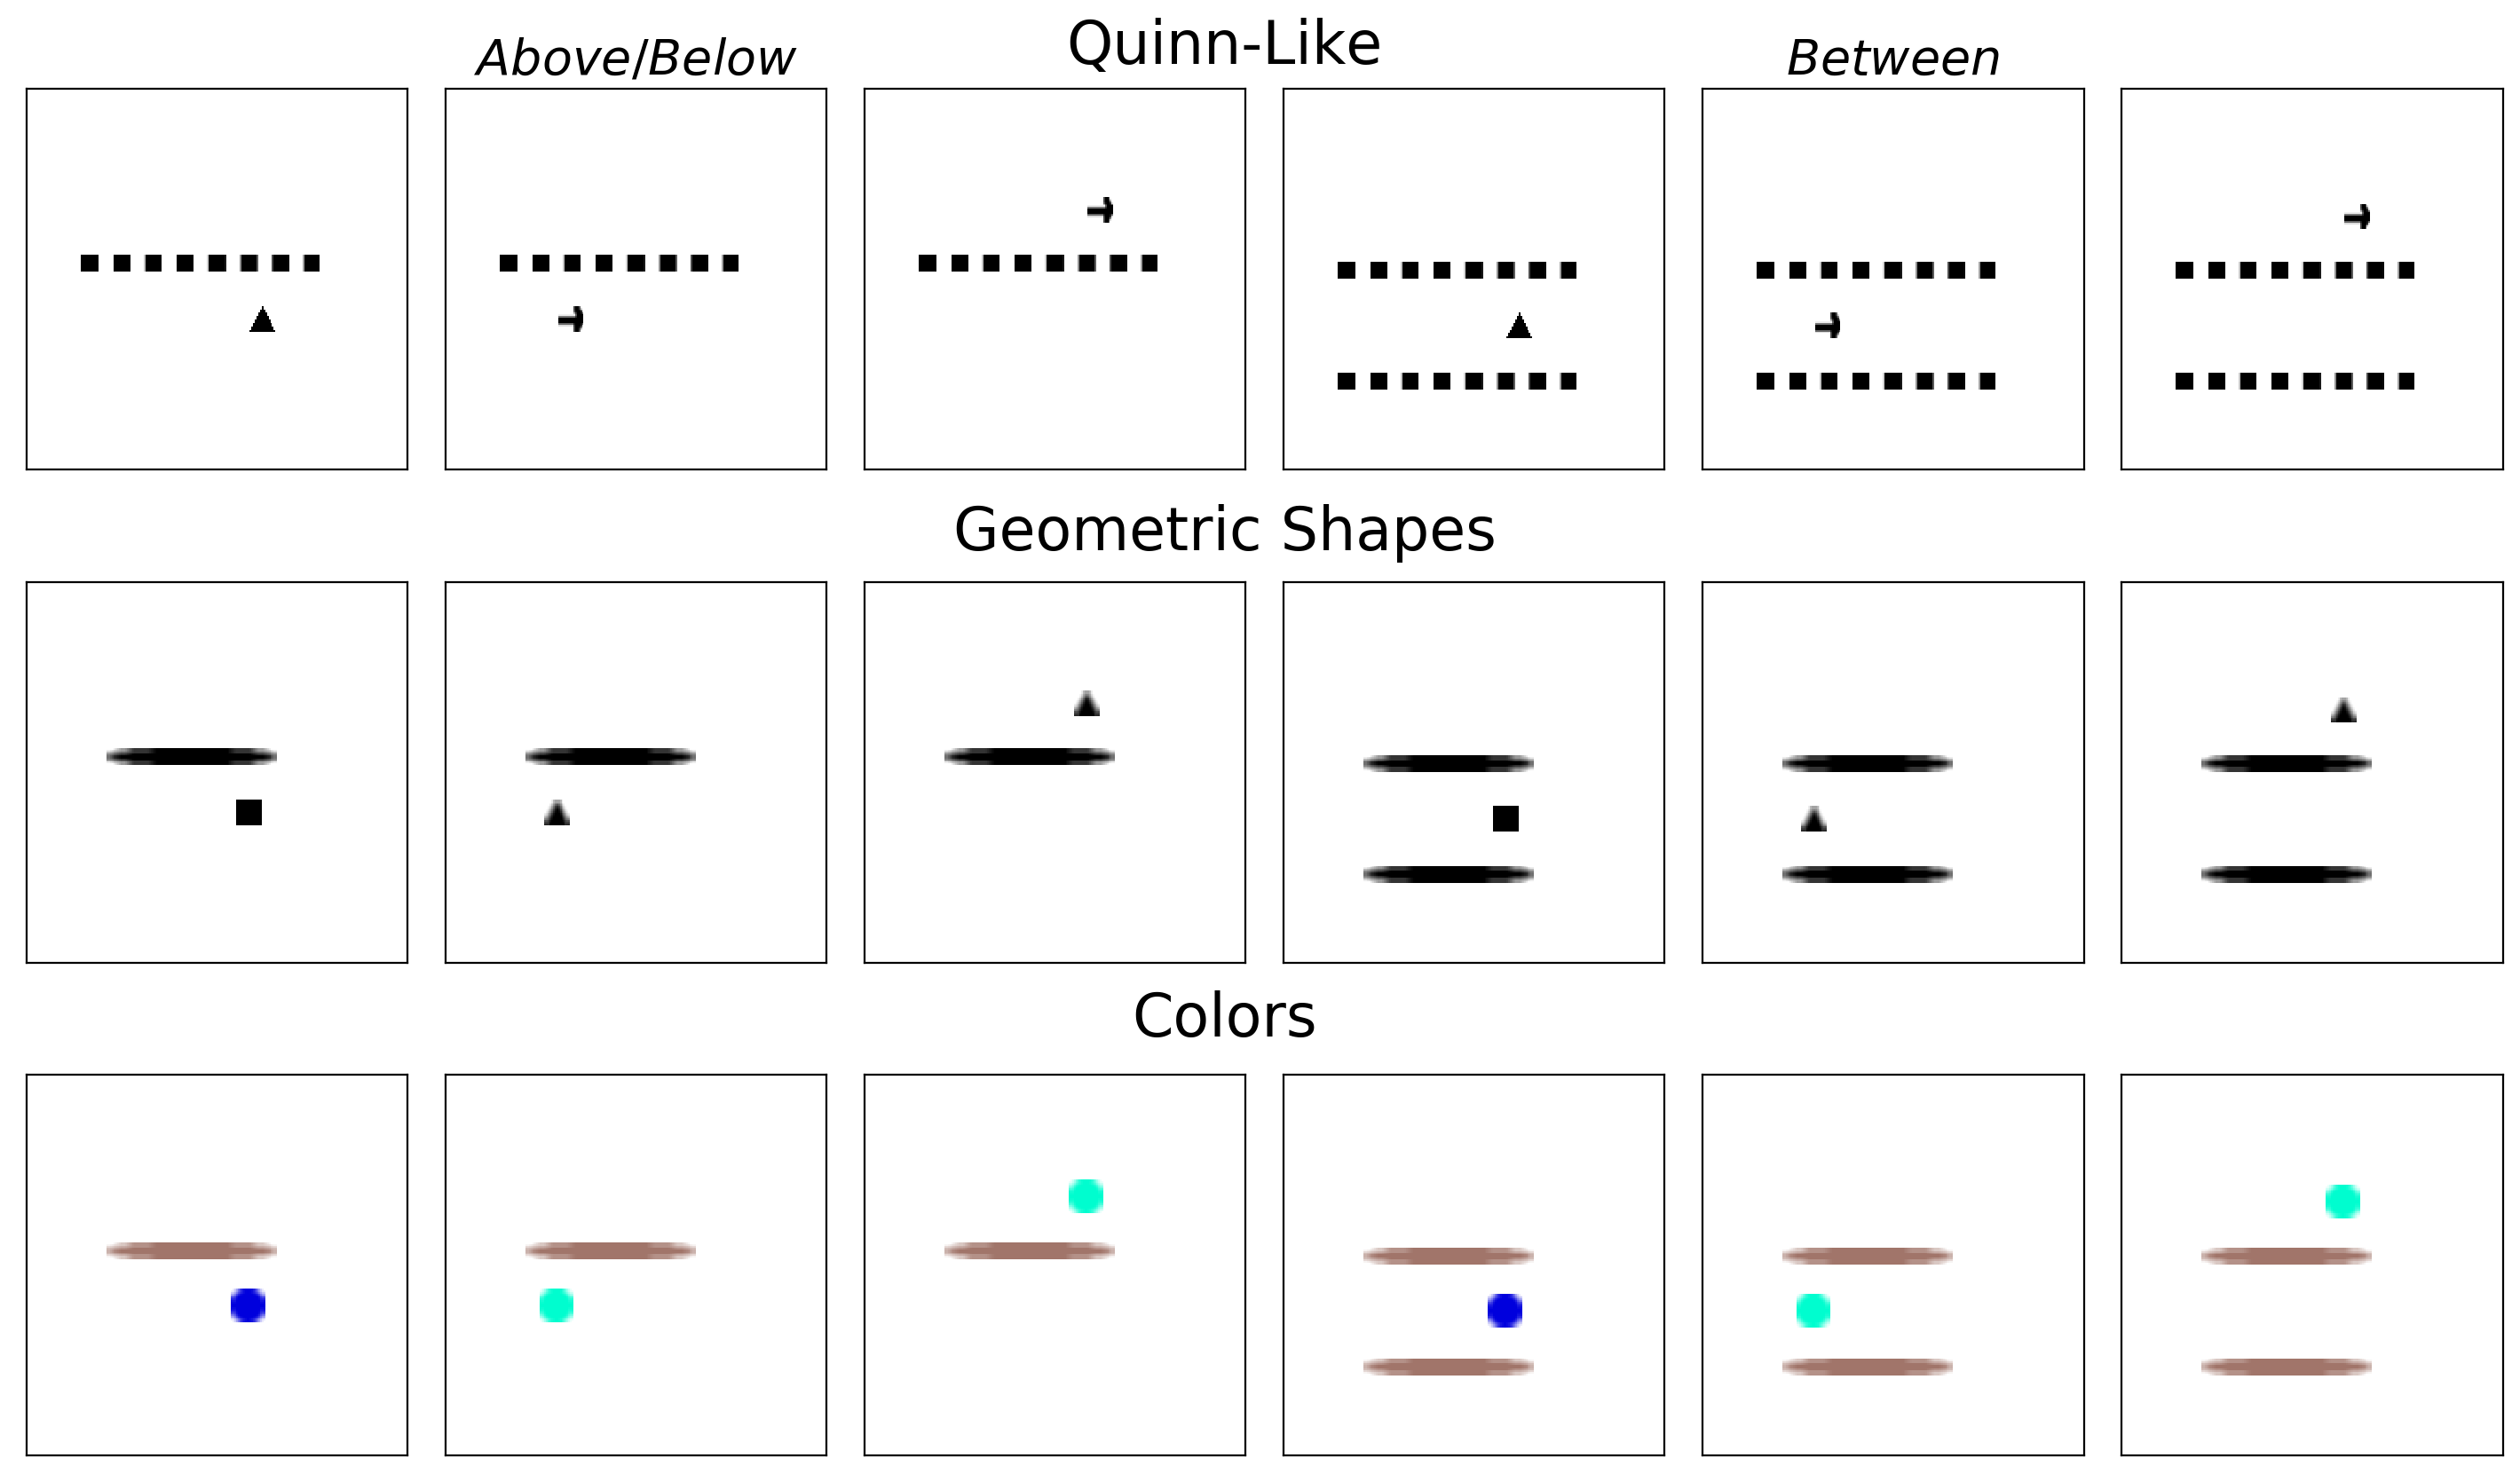

In [178]:
c = 23
rng = np.random.default_rng(c)
random_gen = build_random_color_stimulus_generator(rng)

random_color_names, random_color_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, random_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Random-Color'))



triplet_generator_lists = (quinn_split_reference_text_triplet_generators, 
                           quinn_different_shape_triplet_generators,
                           random_color_triplet_generators, )
N_rows = len(triplet_generator_lists)

fig = plt.figure(figsize=(18, 3.15 * N_rows), dpi=200)

row = 0
for triplet_generator_list in triplet_generator_lists:
    col = 0
    for trip_gen in triplet_generator_list:
        if trip_gen.n_target_types == 2 and not trip_gen.transpose:
            triplet = trip_gen(1, normalize=False)
            for sub_col in range(3):
                ax = plt.subplot(N_rows, 6, (row * 6) + (col * 3) + sub_col + 1)
                ax.imshow(triplet[0, sub_col].permute(1, 2, 0).numpy())
                ax.get_xaxis().set_ticks([])
                ax.get_yaxis().set_ticks([])
                if row == 0 and sub_col == 1:
                    if col == 0:
                        ax.set_title('$\\it{Above/Below}$', fontsize=20)
                    else:
                        ax.set_title('$\\it{Between}$', fontsize=20)
            
            col += 1
        
    row += 1
        
fig.text(0.5, .99, 'Quinn-Like', fontsize=24,
        horizontalalignment='center', verticalalignment='center',)

fig.text(0.5, 0.7, 'Geometric Shapes', fontsize=24,
        horizontalalignment='center', verticalalignment='center',)
        
fig.text(0.5, 0.41, 'Colors', fontsize=24,
        horizontalalignment='center', verticalalignment='center',)
fig.subplots_adjust(wspace=0.1, hspace=0.06, top=0.99)

save_plot('exp2_example_stimuli.pdf')

plt.show()